# The Pooling Problem

### Introduction
In the pooling problem, source materials are mixed in intermediate pools to create output products. The outputs are constrained by quality attributes. We consider Haverly's small pooling example:

> C. A. Haverly, *Studies of the behavior of the recursion for the pooling problem*, SIGMAP Bulletin, 25 (1978), pp. 19-28.

### Problem Description
- **Three sources** of oil with different sulfur percentages
- Blended to create **two oil products** with requirements on:
  - Sulfur content (%)
  - Production quantity



In [1]:
from gurobipy import *

### Define data
Now, we define the data used in Haverly's 1978 paper.

In [3]:
# Define the crudel oil sources, cost per unit, and sulfur percentage (i.e., quality)
sources, costs, sulfur = multidict({
    "A" : [6, 3],
    "B" : [16, 1],
    "C" : [10, 2]
})

# Define the crude oil sinks, market price, maximum sulfur percentage (quality), and maximum satisfiable demand
sinks, price, max_sulfur, demand = multidict({
    "X" : [9, 2.5, 100],
    "Y" : [15, 1.5, 200]
})

# Define intermediate pools 
pools = ["P"]

# Node connections (i.e. graph edges)
connections = tuplelist([
    ("A", "P"), ("B", "P"),      # Connections to pool
    ("P", "X"), ("P", "Y"),      # Connections from pool to sink
    ("C", "X"), ("C", "Y")       # Direct connections
])

### Visualizing the problem
We can draw the directed graph with the <code>graphviz</code> package.

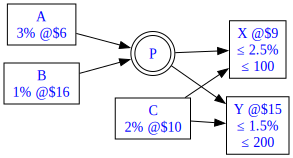

In [5]:
from graphviz import Digraph
dot = Digraph(graph_attr={'rankdir' : 'LR'}, node_attr={'fontcolor' : 'blue', 'shape' : 'box'})
for pool in pools:
    dot.node(pool, shape='doublecircle')
for sink in sinks:
    dot.node(sink, "{:s} @${:d}\n\u2264 {:0.1f}%\n \u2264 {:d}".format(sink, price[sink], max_sulfur[sink], demand[sink]))
for source in sources:
    dot.node(source, "{:s}\n {:d}% @${:d}".format(source, sulfur[source], costs[source]))
for connection in connections:
    dot.edge(*connection)
dot

#### Mathematical Formulation

Let:
- $N = \{A, B, C, P, X, Y\}$ be the set of nodes in the graph
- $A$ be the set of arcs

We create two sets of variables:
- **Flow variables**: $x_{ij}$ for the arcs $(i, j) \in A$
- **Quality variables**: $y_i$ (sulfur percentage) for nodes $i \in N$

Parameters:
- For source nodes $i \in S := \{A, B, C\}$:
  - $f_i$ = fixed sulfur percentage
  - $c_i$ = unit cost
- For sink nodes $i \in T := \{X, Y\}$:
  - $u_i$ = maximum sulfur percentage
  - $p_i$ = unit selling price
  - $d_i$ = maximum demand

#### Optimization Model

**Objective** (Maximize profit):
$$
\max_{x,y} \sum_{i \in T} \sum_{(j,i) \in A} p_i x_{ji} - \sum_{i \in S} \sum_{(i,j) \in A} c_i x_{ij}
$$

**Subject to**:

1. Flow balance:
$$
\sum_{(j,i) \in A} x_{ji} = \sum_{(i,j) \in A} x_{ij} \quad \forall i \in N \setminus (S \cup T)
$$

2. Quality definition:
$$
y_i \sum_{(j,i) \in A} x_{ji} = \sum_{(j,i) \in A} y_j x_{ji} \quad \forall i \in N
$$

3. Fixed source quality:
$$
y_i = f_i \quad \forall i \in S
$$

4. Sink quality bound:
$$
y_i \leq u_i \quad \forall i \in T
$$

5. Maximum demand:
$$
\sum_{(j,i) \in A} x_{ji} \leq d_i \quad \forall i \in T
$$

6. Non-negativity:
$$
x, y \geq 0
$$

We can model this problem using `gurobipy`.

### Variables and bounds

In [7]:
def define_variables(m):

    # Total flow per connection
    flow = m.addVars(connections, name="flow")

    # Quality (percentage of sulfur after blending all inflow)
    quality = m.addVars(sources + pools + sinks, name="quality")

    # Fix quality for all sources
    for source in sources:
        quality[source].LB = sulfur[source]
        quality[source].UB = sulfur[source]

    # Bound minimum quality for all sinks
    for sink in sinks:
        quality[sink].UB = max_sulfur[sink]

    return flow, quality

### Objective functions (profit)

In [10]:
def define_objective(m, flow, quality):

    # Build objective function
    total_costs = sum(costs[i] * flow[i,j] for s in sources for i,j in connections.select(s, '*'))
    total_revenue = sum(price[j] * flow[i,j] for t in sinks for i,j in connections.select('*', t))
    m.setObjective(total_revenue - total_costs, GRB.MAXIMIZE)

### Constraints

In [12]:
def define_constraints(m, flow, quality):

    # Add balance constraints
    m.addConstrs((flow.sum('*', pool) == flow.sum(pool, '*') for pool in pools), name="balance")

    # Add demand constraints
    m.addConstrs((flow.sum('*', j) <= demand[j] for j in sinks), name="demand")

    # Add quality constraints
    m.addConstrs((quality[node] * flow.sum('*', node)
                 == sum(quality[i] * flow[i,j] for i,j in connections.select('*', node))
                 for node in pools + sinks), name="quality")

Now, we let Gurobi build and solve the model

In [14]:
m = Model()

flow, quality = define_variables(m)
define_objective(m, flow, quality)
define_constraints(m, flow, quality)

m.params.NonConvex=2
m.optimize()

Set parameter Username
Set parameter LicenseID to value 2588857
Academic license - for non-commercial use only - expires 2025-11-22
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 3 rows, 12 columns and 8 nonzeros
Model fingerprint: 0x08336c3a
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+02, 2e+02]
Presolve removed 0 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 38 rows, 18 columns, 80 non

### Visualize flows

In [22]:
def draw_solution(m, flow, quality):
    dot = Digraph(graph_attr={'rankdir' : 'LR'}, node_attr={'fontcolor' : 'blue', 'shape' : 'box'})

    # Add pool nodes
    for pool in pools:
        dot.node(pool, shape='doublecircle')

    # Add sink nodes with solution values
    for sink in sinks:
        total_flow = sum(f.X for f in flow.select('*', sink))
        dot.node(sink, label=f"<{sink} <br/> ({total_flow:g})>", shape='invhouse')

    # Add connections with flow and quality information
    for connection in connections:
        if flow[connection].X > 0:   # only show non-zero flows
            dot.edge(
                connection[0], connection[1],
                label=f'{flow[connection].X:g} @ {quality[connection[0]].X:g}%' ,
                color='red',
                fontname='courier',
                fontsize='10'
            )
        else:
            dot.edge(
                connection[0], connection[1],
                color='lightgray',
                fontname='courier',
                fontsize='10'
            )
    return dot

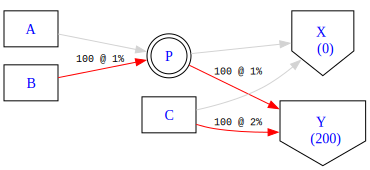

In [24]:
draw_solution(m, flow, quality)

### Changing the data

#### Increasing demand
We increase the maximum demand of product X from 100 to 600 and solve the model again.

In [29]:
demand['X'] = 600

m2 = Model()

flow2, quality2 = define_variables(m2)
define_objective(m2, flow2, quality2)
define_constraints(m2, flow2, quality2)

m2.params.NonConvex=2
m2.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 3 rows, 12 columns and 8 nonzeros
Model fingerprint: 0x9ef48f91
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 0 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 38 rows, 18 columns, 80 nonzeros
Presolved model has 8 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller boun

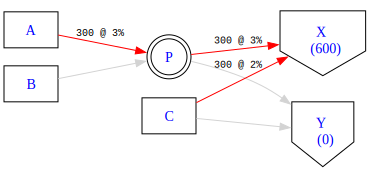

In [31]:
# Draw solution
draw_solution(m2, flow2, quality2)

### Changing source price

We lower the price of extracting crude oil from source B from `$16` to `$13`.

In [48]:
costs['B'] = 13

m3 = Model()
flow3, quality3 = define_variables(m3)
define_objective(m3, flow3, quality3)
define_constraints(m3, flow3, quality3)

m3.params.NonConvex=2
m3.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 3 rows, 12 columns and 8 nonzeros
Model fingerprint: 0x78e7e70b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 3e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 0 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolved: 38 rows, 18 columns, 80 nonzeros
Presolved model has 8 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller boun

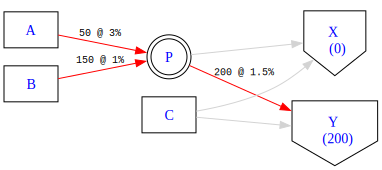

In [52]:
# Draw solution
draw_solution(m3, flow3, quality3)